1. [Configuración del entorno de trabajo](1st_delivery_intro.ipynb)
2. [Carga inicial de datos](1st_delivery_intro.ipynb)
3. [Tratamiento de campos semi-estructurados](1st_delivery_intro.ipynb)
4. [Análisis exploratorio y evaluación de calidad de datos](#análisis-exploratorio-y-evaluación-de-calidad-de-datos)
    - [Productos](#tabla-productos)
    - [Usuarios](#tabla-usuarios)
    - [Categorías](#tabla-categorías)
    - [Órdenes](#tabla-ordenes)
    - [Detalle de Órdenes](#tabla-detalleordenes)
    - [Direcciones de Envío](#tabla-direcciones-de-envío)
    - [Carrito](#tabla-carrito)
    - [Métodos de Pago](#tabla-métodos-de-pago)
    - [Órdenes Métodos de Pago](#tabla-órdenes-métodos-de-pago)
    - [Reseñas de Productos](#tabla-reseñas-de-productos)
    - [Historial de Pagos](#tabla-historial-de-pagos)

# ENTREGABLE 1

## 2.Implementar análisis exploratorio complementario en Python mediante un ORM (como SQLAlchemy o psycopg2).

- Se explora información de las tablas y tipos de datos con pandas 

### Tabla: Productos

In [1]:
from app.utils import notebook_utils

notebook_utils.show_table_data("Productos")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductoID   36 non-null     int64  
 1   Nombre       36 non-null     object 
 2   Descripcion  36 non-null     object 
 3   Precio       36 non-null     float64
 4   Stock        36 non-null     int64  
 5   CategoriaID  36 non-null     int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.8+ KB


None

,ProductoID,Nombre,Descripcion,Precio,Stock,CategoriaID
0,1,Smartphone Galaxy A54,Teléfono inteligente con pantalla AMOLED y cám...,349.99,50,1
1,2,Laptop Dell Inspiron 15,Laptop para trabajo y estudio con procesador I...,799.00,30,1
2,3,Auriculares Bluetooth Sony,Auriculares inalámbricos con cancelación de ru...,129.99,100,1
3,4,Camiseta Básica Hombre,Camiseta de algodón 100% disponible en varias ...,14.99,200,2
4,5,Jeans Skinny Mujer,Jeans corte skinny de mezclilla azul.,39.99,150,2


#### 1. Información general

* Número de registros únicos: 36
* Número de columnas: 6

#### 2. Esquema

| Columna     | Tipo de dato | Valores no nulos | Observaciones                      |
| ----------- | ------------ | ---------------- | ---------------------------------- |
| ProductoID  | int64        | 36               | Clave primaria.         |
| Nombre      | object       | 36               | Texto. No hay valores faltantes.   |
| Descripcion | object       | 36               | Texto. Puede contener redundancia. |
| Precio      | float64      | 36               | Valor numérico.                    |
| Stock       | int64        | 36               | Unidades disponibles.              |
| CategoriaID | int64        | 36               | Clave foránea a `Categorias`.      |

Observaciones
* No hay columnas con valores nulos.
* Estructura: los tipos de datos parecen consistentes al atributo que describen
* Las claves numéricas (ProductoID, CategoriaID) son consistentes.

In [2]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("Productos")

ProductoID     0.0
Nombre         0.0
Descripcion    0.0
Precio         0.0
Stock          0.0
CategoriaID    0.0
dtype: float64

np.int64(0)

In [3]:
from app.utils import postgres_utils,notebook_utils

query_names_duplicates = """
SELECT "Nombre", "Descripcion", COUNT(*) as count
FROM "Productos"
GROUP BY "Nombre", "Descripcion"
HAVING COUNT(*) > 1;
"""
data_frame = postgres_utils.run_query(query_names_duplicates)
data_count = data_frame.shape[0]

notebook_utils.print_colored(f"Cantidad de productos con nombres duplicados: {data_count}", "green")
data_frame

,Nombre,Descripcion,count


#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** Las claves numéricas (ProductoID, CategoriaID) son consistentes. 

* * **Clave primaria(s):** ProductoID, es unico y sin nulos

* * **Claves foráneas:** CategoriaID

In [3]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("Productos")

,ProductoID,Precio,Stock,CategoriaID
count,36.000000,36.000000,36.000000,36.00000
mean,18.500000,86.083611,87.777778,6.50000
std,10.535654,164.246313,58.449544,3.50102
min,1.000000,4.500000,20.000000,1.00000
25%,9.750000,19.467500,50.000000,3.75000
50%,18.500000,30.995000,77.500000,6.50000
75%,27.250000,56.247500,102.500000,9.25000
max,36.000000,799.000000,300.000000,12.00000


#### 4. Anáslisis estadístico

__Precio__: La desviación estándar es muy alta ($164.25), indicando gran dispersión.

* * El máximo valor registrado ($799.00) sugiere posible presencia de outliers.

* *  El 25% de los productos cuesta menos de $19.47.

__Stock__: El promedio de unidades en stock es 87.78, con un mínimo de 20 y un máximo de 300.

También se observa una alta dispersión (std = 58.45), lo que sugiere que hay productos con niveles de stock muy dispares.

In [4]:
from app.utils import postgres_utils
query = """
SELECT *FROM "Productos"
ORDER BY "Precio" DESC
LIMIT 10;
"""
postgres_utils.run_query(query)

,ProductoID,Nombre,Descripcion,Precio,Stock,CategoriaID
0,2,Laptop Dell Inspiron 15,Laptop para trabajo y estudio con procesador I...,799.00,30,1
1,34,Consola PlayStation 5,Consola de videojuegos de última generación.,549.99,20,12
2,1,Smartphone Galaxy A54,Teléfono inteligente con pantalla AMOLED y cám...,349.99,50,1
3,10,Bicicleta Montaña Aro 29,Bicicleta para adulto con cambios Shimano.,299.00,20,4
4,3,Auriculares Bluetooth Sony,Auriculares inalámbricos con cancelación de ru...,129.99,100,1
5,32,Mini Proyector LED,Proyector portátil para películas o presentaci...,75.00,35,11
6,36,Juego FIFA 24 - PS5,Juego de fútbol con licencias oficiales.,69.99,30,12
7,6,Zapatillas Deportivas,Calzado deportivo para running o uso casual.,59.99,80,2
8,35,Control Xbox Series X,Mando inalámbrico con vibración y grip.,59.99,50,12
9,14,Perfume Hombre 100ml,Fragancia fresca y duradera.,55.00,40,5


Number of outliers in 'Precio': 5


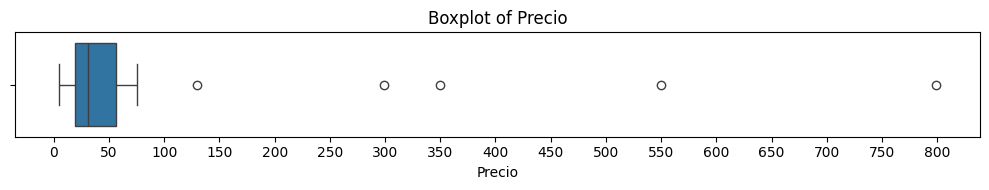

Number of outliers in 'Stock': 3


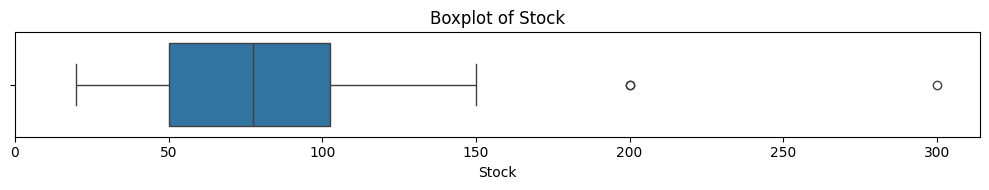

In [5]:
from app.utils import plot_utils

outliers_price, lower_price, upper_price = plot_utils.plot_boxplot_with_outliers('Productos', 'Precio', step=50)

outliers_stock, lower_stock, upper_stock = plot_utils.plot_boxplot_with_outliers('Productos', 'Stock', step=50)

#### 5. Preguntas de negocio

##### 5.1. ¿Qué productos tienen alto stock pero bajas ventas?

In [6]:
from app.utils import postgres_utils, notebook_utils

query = """
SELECT 
    p."ProductoID",
    p."Nombre",
    p."Stock",
    COALESCE(SUM(d."Cantidad"), 0) AS total_vendido
FROM "Productos" p
LEFT JOIN "DetalleOrdenes" d ON p."ProductoID" = d."ProductoID"
GROUP BY p."ProductoID", p."Nombre", p."Stock"
ORDER BY p."Stock" DESC, total_vendido ASC
LIMIT 10;
"""

notebook_utils.print_colored("Productos con alto stock y bajas ventas", "green")

postgres_utils.run_query(query)

,ProductoID,Nombre,Stock,total_vendido
0,23,Cuaderno Universitario 100h,300,876
1,27,Alcohol en Gel 500ml,200,803
2,4,Camiseta Básica Hombre,200,868
3,13,Crema Hidratante Facial,150,818
4,24,Set de Lápices de Colores,150,856
5,5,Jeans Skinny Mujer,150,887
6,7,Sartén Antiadherente 24cm,120,693
7,25,Multivitamínico Centrum,120,836
8,30,Juguete Mordedor Canino,110,840
9,11,Pelota de Fútbol Profesional,100,750


Dado que se observa una variación alta entre mínimo (750 ventas) y mayor volumen (870) de ventas se analiza ranking de ventas para entender si estos valores son bajos, medio o altos 

In [7]:
from app.utils import postgres_utils, notebook_utils

query = """
SELECT 
    p."ProductoID",
    p."Nombre",
    p."Stock",
    COALESCE(SUM(d."Cantidad"), 0) AS total_vendido
FROM "Productos" p
LEFT JOIN "DetalleOrdenes" d ON p."ProductoID" = d."ProductoID"
GROUP BY p."ProductoID", p."Nombre", p."Stock"
ORDER BY total_vendido DESC
LIMIT 10;
"""

notebook_utils.print_colored("Ranking de productos por ventas", "green")
postgres_utils.run_query(query)

,ProductoID,Nombre,Stock,total_vendido
0,18,Juego de Mesa Monopoly,50,942
1,34,Consola PlayStation 5,20,935
2,26,Termómetro Digital,80,898
3,31,Smartwatch Xiaomi Mi Band 8,100,887
4,5,Jeans Skinny Mujer,150,887
5,32,Mini Proyector LED,35,885
6,23,Cuaderno Universitario 100h,300,876
7,29,Arenero para Gato,40,874
8,4,Camiseta Básica Hombre,200,868
9,24,Set de Lápices de Colores,150,856


En base al resultado anterior podría decirse que más de 850 unidades es un valor de ventas alto, con lo cual se ajusta consulta para requerir aquellos con valores muy inferiores (a pesar que ya la muestra tiene como minimo 0 ventas)

In [24]:
from app.utils import notebook_utils, postgres_utils

query = """
SELECT *
FROM (
    SELECT 
        p."ProductoID",
        p."Nombre",
        p."Stock",
        COALESCE(SUM(d."Cantidad"), 0) AS total_vendido
    FROM "Productos" p
    RIGHT JOIN "DetalleOrdenes" d ON p."ProductoID" = d."ProductoID"
    GROUP BY p."ProductoID", p."Nombre", p."Stock"
) sub
WHERE sub.total_vendido <800
ORDER BY sub."Stock" DESC
LIMIT 10;
"""
notebook_utils.print_colored("Productos con alto stock y bajas ventas (< 500)", "green")
postgres_utils.run_query(query)

,ProductoID,Nombre,Stock,total_vendido
0,7,Sartén Antiadherente 24cm,120,693
1,11,Pelota de Fútbol Profesional,100,750
2,33,"Power Bank 20,000mAh",70,777
3,15,Plancha para Cabello Remington,70,707
4,20,Limpiaparabrisas Universal,60,777
5,12,Mochila Deportiva Nike,50,771
6,14,Perfume Hombre 100ml,40,770
7,21,Cámara de Reversa,40,777
8,10,Bicicleta Montaña Aro 29,20,757


##### 5.2. ¿Cuántos productos están actualmente fuera de stock?


In [25]:
from app.utils import notebook_utils, postgres_utils
query = """
SELECT COUNT(*) AS total_out_of_stock
FROM "Productos"
WHERE "Stock" = 0;
"""
out_of_stock_count = postgres_utils.run_query(query)
notebook_utils.print_colored(f"Total de productos fuera de stock: {out_of_stock_count['total_out_of_stock'][0]}", "green")


No hay productos sin stock al momento

##### 5.3. ¿Cuáles son los productos peor calificados?


In [26]:
from app.utils import postgres_utils, notebook_utils

query = """SELECT 
    p."ProductoID",
    p."Nombre",
    p."Stock",
    COALESCE(SUM(d."Cantidad"), 0) AS total_vendido,
    AVG(r."Calificacion") AS promedio_calificacion
FROM "Productos" p
LEFT JOIN "DetalleOrdenes" d ON p."ProductoID" = d."ProductoID"
LEFT JOIN "ReseñasProductos" r ON p."ProductoID" = r."ProductoID"
GROUP BY p."ProductoID", p."Nombre", p."Stock"
HAVING AVG(r."Calificacion") IS NOT NULL
ORDER BY promedio_calificacion ASC
LIMIT 10;"""
notebook_utils.print_colored("Productos peor calificados", "green")
postgres_utils.run_query(query)

,ProductoID,Nombre,Stock,total_vendido,promedio_calificacion
0,25,Multivitamínico Centrum,120,245784,2.846939
1,6,Zapatillas Deportivas,80,217800,2.886364
2,1,Smartphone Galaxy A54,50,216783,2.895753
3,26,Termómetro Digital,80,264910,2.922034
4,19,Aceite de Motor 5W30,80,231256,2.923358
5,3,Auriculares Bluetooth Sony,100,224406,2.927007
6,21,Cámara de Reversa,40,224553,2.927336
7,11,Pelota de Fútbol Profesional,100,239250,2.949843
8,22,Libro: Cien Años de Soledad,100,231574,2.956835
9,24,Set de Lápices de Colores,150,239680,2.957143


##### 5.4. ¿Qué productos tienen mayor cantidad de reseñas?


In [27]:
from app.utils import postgres_utils, notebook_utils

query = """SELECT 
    p."ProductoID",
    p."Nombre",
    COUNT(r."ReseñaID") AS total_reseñas
FROM "Productos" p
LEFT JOIN "ReseñasProductos" r ON p."ProductoID" = r."ProductoID"
GROUP BY p."ProductoID", p."Nombre"
ORDER BY total_reseñas DESC
LIMIT 10;"""

notebook_utils.print_colored("Productos con mayor cantidad de reseñas", "green")
postgres_utils.run_query(query)

,ProductoID,Nombre,total_reseñas
0,11,Pelota de Fútbol Profesional,319
1,18,Juego de Mesa Monopoly,304
2,8,Juego de Sábanas Queen,304
3,20,Limpiaparabrisas Universal,299
4,26,Termómetro Digital,295
5,25,Multivitamínico Centrum,294
6,4,Camiseta Básica Hombre,293
7,10,Bicicleta Montaña Aro 29,290
8,28,Alimento para Perro 10kg,289
9,21,Cámara de Reversa,289


##### 5.5. ¿Qué categoría tiene el mayor valor económico vendido (no solo volumen)?

In [28]:

from app.utils import postgres_utils, notebook_utils
query = """SELECT 
    c."CategoriaID",
    c."Nombre" AS categoria,
    SUM(d."Cantidad" * p."Precio") AS valor_vendido
FROM "Categorias" c
JOIN "Productos" p ON c."CategoriaID" = p."CategoriaID"
LEFT JOIN "DetalleOrdenes" d ON p."ProductoID" = d."ProductoID"
GROUP BY c."CategoriaID", c."Nombre"
ORDER BY valor_vendido DESC
LIMIT 10;"""
notebook_utils.print_colored("Categorías con mayor valor económico vendido", "green")
postgres_utils.run_query(query)

,CategoriaID,categoria,valor_vendido
0,1,Electrónica,1076156.44
1,12,Videojuegos,625073.60
2,4,Deportes y Aire Libre,275820.50
3,11,Tecnología y Gadgets,129503.53
4,2,Moda,97974.20
5,5,Belleza y Cuidado Personal,87598.32
6,6,Juguetes y Juegos,79108.20
7,3,Hogar y Cocina,76809.71
8,7,Automotriz,62443.33
9,10,Mascotas,57023.26


In [29]:
from app.utils import postgres_utils, notebook_utils

query = """SELECT 
    c."CategoriaID",
    c."Nombre" AS categoria,
    COUNT(d."Cantidad") AS total_vendido
FROM "Categorias" c
JOIN "Productos" p ON c."CategoriaID" = p."CategoriaID"
LEFT JOIN "DetalleOrdenes" d ON p."ProductoID" = d."ProductoID"
GROUP BY c."CategoriaID", c."Nombre"
ORDER BY total_vendido DESC
LIMIT 10;"""
notebook_utils.print_colored("Ranking de categorías por ventas", "green")
postgres_utils.run_query(query)

,CategoriaID,categoria,total_vendido
0,2,Moda,877
1,6,Juguetes y Juegos,865
2,8,Libros y Papelería,860
3,12,Videojuegos,857
4,10,Mascotas,846
5,1,Electrónica,842
6,11,Tecnología y Gadgets,841
7,9,Salud,820
8,3,Hogar y Cocina,820
9,7,Automotriz,800


In [30]:
from app.utils import postgres_utils, notebook_utils

query = """SELECT 
    c."CategoriaID",
    c."Nombre" AS categoria,
    AVG(p."Precio") AS precio_promedio
FROM "Categorias" c
JOIN "Productos" p ON c."CategoriaID" = p."CategoriaID"
GROUP BY c."CategoriaID", c."Nombre"
ORDER BY precio_promedio DESC
LIMIT 10;"""

notebook_utils.print_colored("Ranking de categorías por precio unitario promedio", "green")
postgres_utils.run_query(query)

,CategoriaID,categoria,precio_promedio
0,1,Electrónica,426.326667
1,12,Videojuegos,226.656667
2,4,Deportes y Aire Libre,121.330000
3,11,Tecnología y Gadgets,49.963333
4,5,Belleza y Cuidado Personal,38.830000
5,2,Moda,38.323333
6,3,Hogar y Cocina,31.826667
7,6,Juguetes y Juegos,29.993333
8,7,Automotriz,26.130000
9,10,Mascotas,22.163333


### 6. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `Productos`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 6.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** No se requiere imputación o eliminación. Se mantiene la estructura original.

#### 6.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto. Se recomienda mantener chequeos periódicos al integrar datos nuevos.

#### 6.3 Valores atípicos

- **Diagnóstico:** Se identificaron valores atípicos en la columna `Precio`, con un máximo de 799 (muy por encima del tercer cuartil).
- **Acción propuesta:** 
  - Validar si esos valores son errores de carga o válidos.
  - Si se confirma que son errores, se sugiere establecer un límite superior al menos a instancias de reporte.
  - Si son válidos, mantenerlos pero tenerlos en cuenta para normalizaciones o transformaciones.

#### 6.4 Consistencia de claves

- **ProductoID:** clave primaria válida, sin duplicados ni nulos.
- **CategoriaID:** clave foránea consistente con la tabla `Categorias`.

- **Acción propuesta:**  Asegurar que al importar datos se mantenga integridad referencial. Puede implementarse con constraints.

#### 6.5 Texto libre

- **Diagnóstico:** Las columnas `Nombre` y `Descripcion` son campos de texto libre.
- **Acción propuesta:** 
  - Normalizar capitalización.
  - Eliminar espacios dobles o caracteres especiales si existieran.

#### 6.6 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.
- **Acción:** Sin cambios requeridos.

---

**Resumen general:**

| Aspecto             | Acción requerida          |
|---------------------|-------------------------- |
| Valores nulos       | No                        |
| Duplicados          | No                        |
| Outliers            | Validar precios extremos  |
| Claves              | Confirmar constraints     |
| Texto libre         | Normalización recomendada |
| Tipos de datos      | Consistentes              |


### Tabla: Usuarios

In [8]:
from app.utils import notebook_utils

notebook_utils.show_table_data("Usuarios")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UsuarioID      1000 non-null   int64         
 1   Nombre         1000 non-null   object        
 2   Apellido       1000 non-null   object        
 3   DNI            1000 non-null   object        
 4   Email          1000 non-null   object        
 5   Contraseña     1000 non-null   object        
 6   FechaRegistro  1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 54.8+ KB


None

,UsuarioID,Nombre,Apellido,DNI,Email,Contraseña,FechaRegistro
0,1,Encarna,Donaire,49877134,encarna.donaire1@correo.com,Contraseña123,2025-07-22 21:44:41.060272
1,2,Jose Ignacio,Canales,98778810,jose ignacio.canales2@correo.com,Contraseña123,2025-07-22 21:44:41.060272
2,3,José,Sebastián,80095714,josé.sebastián3@correo.com,Contraseña123,2025-07-22 21:44:41.060272
3,4,Priscila,Vilar,94128750,priscila.vilar4@correo.com,Contraseña123,2025-07-22 21:44:41.060272
4,5,Epifanio,Ríos,62958342,epifanio.ríos5@correo.com,Contraseña123,2025-07-22 21:44:41.060272


#### 1. Información general

* Número de registros: 1000
* Número de columnas: 7

#### 2. Esquema

| Columna       | Tipo de dato | Valores no nulos | Observaciones                         |
| -----------   | ------------ | ---------------- | --------------------------------------|
| UsuarioID     | int64        | 1000             | Clave primaria.                       |
| Nombre        | object       | 1000             | Texto. No hay valores faltantes.      |
| Apellido      | object       | 1000             | Texto.                                |
| email         | object       | 1000             | texto.                                |
| Contraseña    | object       | 1000             | Unidades disponibles.                 |
| FechaRegistro | datetime     | 1000             | Fecha registro de usuario, default now|

Observaciones
* No hay columnas con valores nulos.
* Estructura: los tipos de datos parecen consistentes al atributo que describen
* La columna `Contraseña` debería almacenar un hash, no texto plano.

In [25]:
notebook_utils.show_duplicates_and_null_info("Usuarios")

UsuarioID        0.0
Nombre           0.0
Apellido         0.0
DNI              0.0
Email            0.0
Contraseña       0.0
FechaRegistro    0.0
dtype: float64

np.int64(0)

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** Las claves numéricas (UsuarioID) son consistentes. 

* * **Clave primaria(s):** UsuarioID, es unico y sin nulos

* * **Claves foráneas:** -

In [ ]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("Usuarios")

,UsuarioID,FechaRegistro
count,1000.000000,1000
mean,500.500000,2025-07-21 03:28:30.430114048
min,1.000000,2025-07-21 03:28:30.430114
25%,250.750000,2025-07-21 03:28:30.430114048
50%,500.500000,2025-07-21 03:28:30.430114048
75%,750.250000,2025-07-21 03:28:30.430114048
max,1000.000000,2025-07-21 03:28:30.430114
std,288.819436,NaN


In [18]:
from app.utils import postgres_utils

query_emails_duplicates = """
SELECT "Email", COUNT(*) as count
FROM "Usuarios"
GROUP BY "Email"
HAVING COUNT(*) > 1;
"""
postgres_utils.run_query(query_emails_duplicates).nunique()


Email    0
count    0
dtype: int64

In [20]:
from app.utils import postgres_utils

query_dni_duplicates = """
SELECT "DNI", COUNT(*) as count
FROM "Usuarios"
GROUP BY "DNI"
HAVING COUNT(*) > 1;
"""
postgres_utils.run_query(query_dni_duplicates).nunique()


DNI      0
count    0
dtype: int64

__Observación__ : No hay emails ni DNI duplicados. Sin embargo, se recomienda restricción o validación para prevenir mismo email a diferentes usuarios

#### 4. Anáslisis estadístico
* No se incluyen estadísticos detallados ya que los valores numéricos (UsuarioID y FechaRegistro) no aportan información relevante al momento.

#### 5. Preguntas de negocio

* ¿Cuántos usuarios se registran por mes? 

* ¿Cuántos usuarios han realizado más de una orden?

* ¿Cuántos usuarios registrados no han hecho ninguna compra?

* ¿Qué usuarios han gastado más en total?

* ¿Cuántos usuarios han dejado reseñas?

In [7]:
from app.utils import postgres_utils, notebook_utils
query = """
SELECT 
    DATE_TRUNC('month', "FechaRegistro") AS register_month, 
    COUNT(*) AS users 
FROM "Usuarios" 
GROUP BY register_month 
ORDER BY register_month
"""

notebook_utils.print_colored("¿Cuántos usuarios se registran por mes?", "green")

postgres_utils.run_query(query)


,register_month,users
0,2025-07-01,1000


__Observación__: Todos los registros comparten el mismo valor en FechaRegistro (probablemente default del sistema), lo que invalida el análisis por mes. Se descarta esta dimensión hasta contar con datos representativos.

In [4]:
from app.utils import postgres_utils, notebook_utils
query = """
SELECT 
    COUNT(DISTINCT "UsuarioID") AS users_with_multiple_orders
FROM "Ordenes"
WHERE "UsuarioID" IN (
    SELECT "UsuarioID"
    FROM "Ordenes"
    GROUP BY "UsuarioID"
    HAVING COUNT(*) > 1
);
"""

notebook_utils.print_colored("¿Cuántos usuarios han realizado más de una orden?", "green")

postgres_utils.run_query(query)

,users_with_multiple_orders
0,999


__Observación__: El total de usuarios registrados ha comprado al menos una vez. Seria interesante conocer fecha de regitstro real para conocer tiempo que demora el registro en convertirse a  comprador.

In [10]:

from app.utils import postgres_utils, notebook_utils
query = """
SELECT 
    "UsuarioID",
    SUM("Total") AS total_spent
FROM "Ordenes"
GROUP BY "UsuarioID"
ORDER BY total_spent DESC
LIMIT 10;
"""
notebook_utils.print_colored("¿Qué usuarios han gastado más en total?", "green")
postgres_utils.run_query(query)

,UsuarioID,total_spent
0,411,32342.70
1,379,32341.14
2,951,32152.02
3,25,31643.07
4,382,31487.88
5,878,30877.86
6,15,30336.87
7,390,30298.62
8,913,29765.79
9,892,29654.55


__Observación__: Los mayores compradores registran una alta tasa de compra

In [11]:
from app.utils import postgres_utils, notebook_utils
query = """
SELECT 
    COUNT(DISTINCT "UsuarioID") AS users_with_reviews
FROM "ReseñasProductos";
"""
notebook_utils.print_colored("¿Cuántos usuarios han dejado reseñas?", "green")
postgres_utils.run_query(query)

,users_with_reviews
0,1000


__Observación__: Todos los usuarios han dejado reseñas, lo que indica un alto nivel de interacción con los productos.

### 6. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `Usuarios`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 6.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** No se requiere imputación o eliminación. Se mantiene la estructura original.

#### 6.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto. Se debe garantizar unicidad de DNI e email al realizar nuevos registros

#### 6.3 Valores atípicos

- **Diagnóstico:** No hay valores numericos atípicos. FechaRegistro presenta un valor constante, probablemente por ser una carga masiva o un default.
- **Acción propuesta:** 
  - Validar proceso de carga de fechaRegistro ya que no hay dispersion. Si se quisiera hacer análisis temporal deben proveerse fechas reales.

#### 6.4 Consistencia de claves

- **ProductoID:** clave primaria válida, sin duplicados ni nulos.

- **Acción propuesta:**  Asegurar que al importar datos se mantenga integridad referencial. Puede implementarse con constraints.

#### 6.5 Texto libre

- **Diagnóstico:** `Nombre` y `Descripcion` son campos de texto libre.
- **Acción propuesta:** 
  - Validar formato de email.
  - Eliminar espacios dobles o caracteres especiales si existieran.
  - Normalizar nombres (capitalización).


#### 6.6 Tipos de datos

- **Diagnóstico:** `Contraseña`contiene texto.
- **Acción:** Reemplazar texto plano por hashes y nunca almacenar contraseñas en db 

---

**Resumen general:**

| Aspecto           | Acción requerida                      |
| ----------------- | ------------------------------------- |
| Valores nulos     | No                                    |
| Duplicados        | No                                    |
| Outliers          | No relevantes                         |
| Claves            | Asegurar unicidad  en Email y DNI     |
| Texto libre       | Validar y normalizar                  |
| Seguridad         | Hash de contraseñas requerido         |
| Tipos de datos    | Revisar `Email` y `Contraseña`        |
| Fecha de registro | Revisar dispersión / carga automática |



### Tabla: Categorías

In [ ]:
from app.utils import  notebook_utils

notebook_utils.show_table_data("Categorias")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CategoriaID  12 non-null     int64 
 1   Nombre       12 non-null     object
 2   Descripcion  12 non-null     object
dtypes: int64(1), object(2)
memory usage: 420.0+ bytes


None

,CategoriaID,Nombre,Descripcion
0,1,Electrónica,"Teléfonos, computadoras, accesorios y disposit..."
1,2,Moda,"Ropa, calzado, bolsos y accesorios para hombre..."
2,3,Hogar y Cocina,"Muebles, electrodomésticos, utensilios y decor..."
3,4,Deportes y Aire Libre,"Equipamiento, ropa deportiva y artículos para ..."
4,5,Belleza y Cuidado Personal,"Cosméticos, productos para el cabello, piel y ..."


#### 1. Información general

* Número de registros: 12
* Número de columnas: 3

#### 2. Esquema

| Columna     | Tipo de dato | Valores no nulos | Observaciones                      |
| ----------- | ------------ | ---------------- | ---------------------------------- |
| CategoriaID | int64        | 12               | Clave primaria.                    |
| Nombre      | object       | 12               | Texto. No hay valores faltantes.   |
| Descripcion | object       | 12               | Texto. Puede contener redundancia. |

Observaciones
* No hay columnas con valores nulos.
* Estructura: los tipos de datos parecen consistentes al atributo que describen

In [ ]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("Categorias")

CategoriaID    0.0
Nombre         0.0
Descripcion    0.0
dtype: float64

np.int64(0)

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** 

* * **Clave primaria(s):** CategoriaID, es unico y sin nulos

* * **Claves foráneas:** -

In [3]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("Categorias")

,CategoriaID
count,12.000000
mean,6.500000
std,3.605551
min,1.000000
25%,3.750000
50%,6.500000
75%,9.250000
max,12.000000


#### 4. Anáslisis estadístico
* No se incluyen estadísticos detallados ya que el único valor numérico es el Id

### 5. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `Categorias`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 5.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** No se requiere imputación o eliminación. Se mantiene la estructura original.

#### 5.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados. Sin embargo, en el campo `Nombre` debería garantizarse unicidad. Si dos categorías tienen el mismo nombre (aunque con distinto CategoriaID), podría causar confusión.
- **Acción propuesta:** 
    - Validar unicidad de nombre de categoria  

#### 5.3 Valores atípicos

- **Diagnóstico:** No hay valores numericos atípicos. 

#### 5.4 Consistencia de claves

- **CategoriaID:** clave primaria válida, sin duplicados ni nulos.

#### 5.5 Texto libre

- **Diagnóstico:** `Nombre` y `Descripcion` son campos de texto libre.
- **Acción propuesta:** 
    - Normalizar mayúsculas/minúsculas (ej. todo capitalizado o todo en minúsculas).
    - Eliminar espacios extra antes o después del texto.
    - Eliminar caracteres especiales innecesarios (signos, tabulaciones ocultas).

---

**Resumen general:**

| Aspecto           | Acción requerida                       |
| ----------------- | -------------------------------------  |
| Valores nulos     | No                                     |
| Duplicados        | Prevenir duplicados en columna `Nombre`|
| Outliers          | No relevantes                          |
| Claves            | Asegurar unicidad  en `Nombre`         |
| Texto libre       | Validar y normalizar                   |



#### Tabla: Ordenes

In [1]:
from app.utils import  notebook_utils

notebook_utils.show_table_data("Ordenes")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OrdenID     10000 non-null  int64         
 1   UsuarioID   10000 non-null  int64         
 2   FechaOrden  10000 non-null  datetime64[ns]
 3   Total       10000 non-null  float64       
 4   Estado      10000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 390.8+ KB


None

,OrdenID,UsuarioID,FechaOrden,Total,Estado
0,1,153,2024-09-09 09:10:27,393.81,Enviado
1,2,810,2024-09-29 09:10:27,918.85,Completado
2,3,404,2024-11-03 09:10:27,391.29,Pendiente
3,4,52,2024-09-14 09:10:27,250.03,Cancelado
4,5,811,2025-04-11 09:10:27,983.13,Completado


#### 1. Información general

* Número de registros: 10000
* Número de columnas: 5

#### 2. Esquema

| Columna    | Tipo de dato     | Valores no nulos | Observaciones                                          |
| ---------- | ---------------- | ---------------- | ------------------------------------------------------ |
| OrdenID    | `int64`          | 10,000           | Clave primaria.                                        |
| UsuarioID  | `int64`          | 10,000           | Clave foránea a `Usuarios`.                            |
| FechaOrden | `datetime64[ns]` | 10,000           | Fecha en que se realizó la orden.                      |
| Total      | `float64`        | 10,000           | Monto total en la orden.                               |
| Estado     | `object`         | 10,000           | Estado de la orden (ej. 'Pendiente', 'Completada').    |


Observaciones
* No hay columnas con valores nulos.
* Estructura: los tipos de datos parecen consistentes al atributo que describen
* Las claves numéricas (OrdenID, UsuarioID) son consistentes.

In [2]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("Ordenes")

OrdenID       0.0
UsuarioID     0.0
FechaOrden    0.0
Total         0.0
Estado        0.0
dtype: float64

np.int64(0)

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** 

* * **Clave primaria(s):** OrdenID, es unico y sin nulos

* * **Claves foráneas:** UsuarioID

In [3]:
from app.utils import  notebook_utils

notebook_utils.show_table_stats("Ordenes")

,OrdenID,UsuarioID,FechaOrden,Total
count,10000.00000,10000.000000,10000,10000.000000
mean,5000.50000,503.435500,2024-12-30 15:51:12.120000256,507.762898
min,1.00000,1.000000,2024-06-30 09:10:27,20.110000
25%,2500.75000,258.000000,2024-09-29 09:10:27,262.915000
50%,5000.50000,502.500000,2024-12-31 09:10:27,506.795000
75%,7500.25000,755.000000,2025-04-03 09:10:27,750.382500
max,10000.00000,1000.000000,2025-06-30 09:10:27,999.990000
std,2886.89568,288.442075,NaN,281.766761


#### 4. Anáslisis estadístico

__Total__: La desviación estándar es alta ($281.77), indicando gran dispersión.

* * La media y la mediana están muy próximas (~$507), lo que sugiere una distribución relativamente simétrica.

* * El valor mínimo es de 20.11 y el máximo de 999.99, lo que indica una amplia gama de montos posibles.

* * La desviación estándar es alta (~$281), lo que confirma la dispersión de valores.

* * El 25% de las órdenes tienen un valor inferior a ~262.91 y el 75% están por debajo de ~750.38.


Number of outliers in 'Total': 0


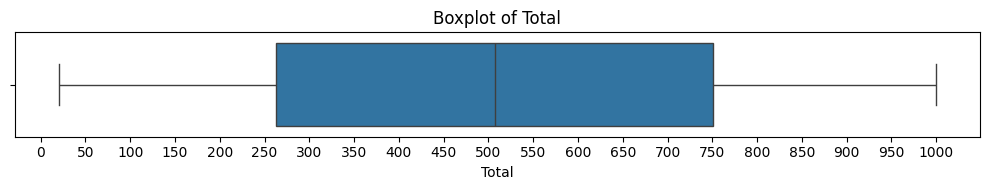

In [4]:
from app.utils import plot_utils

outliers_total, lower_total, upper_total = plot_utils.plot_boxplot_with_outliers('Ordenes', 'Total', step=50)


### 5. Preguntas de Negocio

#### 5.1 ¿Cuáles son los productos más vendidos por volumen?

In [5]:
from app.utils import postgres_utils, notebook_utils

query= """
SELECT 
    p."ProductoID",
    p."Nombre",
    SUM(d."Cantidad") AS total_vendido
FROM "Productos" p
RIGHT JOIN "DetalleOrdenes" d ON p."ProductoID" = d."ProductoID"
GROUP BY p."ProductoID", p."Nombre"
ORDER BY total_vendido DESC
LIMIT 10;
"""
notebook_utils.print_colored("Productos más vendidos por volumen", "green")
postgres_utils.run_query(query)

,ProductoID,Nombre,total_vendido
0,18,Juego de Mesa Monopoly,942
1,34,Consola PlayStation 5,935
2,26,Termómetro Digital,898
3,31,Smartwatch Xiaomi Mi Band 8,887
4,5,Jeans Skinny Mujer,887
5,32,Mini Proyector LED,885
6,23,Cuaderno Universitario 100h,876
7,29,Arenero para Gato,874
8,4,Camiseta Básica Hombre,868
9,24,Set de Lápices de Colores,856


#### 5.2 ¿Cuál es el ticket promedio por orden?

In [6]:
from app.utils import postgres_utils, notebook_utils

query = """
SELECT
    AVG("Total") AS ticket_promedio
    FROM "Ordenes";
"""
notebook_utils.print_colored("Ticket promedio por orden", "green")
postgres_utils.run_query(query)

,ticket_promedio
0,507.762898


#### 5.3 ¿Cuáles son las categorías con mayor número de productos vendidos?


In [7]:
from app.utils import postgres_utils, notebook_utils

query = """
SELECT
    c."CategoriaID",
    c."Nombre" AS categoria,
    COUNT(d."Cantidad") AS total_vendido
FROM "Categorias" c
JOIN "Productos" p ON c."CategoriaID" = p."CategoriaID"
LEFT JOIN "DetalleOrdenes" d ON p."ProductoID" = d."ProductoID"
GROUP BY c."CategoriaID", c."Nombre"
ORDER BY total_vendido DESC
LIMIT 10;
"""
notebook_utils.print_colored("Ranking de categorías por productos vendidos", "green")
postgres_utils.run_query(query)



,CategoriaID,categoria,total_vendido
0,2,Moda,877
1,6,Juguetes y Juegos,865
2,8,Libros y Papelería,860
3,12,Videojuegos,857
4,10,Mascotas,846
5,1,Electrónica,842
6,11,Tecnología y Gadgets,841
7,9,Salud,820
8,3,Hogar y Cocina,820
9,7,Automotriz,800


In [9]:
from app.utils import postgres_utils, notebook_utils

query = """
SELECT
    TO_CHAR("FechaOrden", 'Day') AS dia_semana,
    COUNT(*) AS total_ventas
FROM "Ordenes"
GROUP BY dia_semana
ORDER BY total_ventas DESC;
"""
notebook_utils.print_colored("Ventas por día de la semana", "green")
postgres_utils.run_query(query)

,dia_semana,total_ventas
0,Sunday,1517
1,Saturday,1486
2,Monday,1415
3,Wednesday,1412
4,Friday,1407
5,Tuesday,1385
6,Thursday,1378


Los días de mayor ventas son Domingos, Sábados y Lunes

#### 5.5 ¿Cuántas órdenes se generan cada mes y cuál es su variación?


In [10]:
from app.utils import postgres_utils, notebook_utils
query = """
SELECT
    DATE_TRUNC('month', "FechaOrden") AS mes,
    COUNT(*) AS total_ordenes
FROM "Ordenes"
GROUP BY mes
ORDER BY mes;
"""
notebook_utils.print_colored("Órdenes generadas por mes", "green")
postgres_utils.run_query(query)

,mes,total_ordenes
0,2024-06-01,25
1,2024-07-01,828
2,2024-08-01,864
3,2024-09-01,806
4,2024-10-01,838
5,2024-11-01,807
6,2024-12-01,847
7,2025-01-01,844
8,2025-02-01,747
9,2025-03-01,842


### 4. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `Ordenes`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 4.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** No se requiere imputación o eliminación. Se mantiene la estructura original.

#### 4.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto. Se recomienda mantener chequeos periódicos al integrar datos nuevos.

#### 4.3 Valores atípicos

- **Diagnóstico:** En la columna `Total`, el valor máximo (999.99) es alto respecto al Q3 (750.38), aunque no necesariamente inválido.
- **Acción propuesta:** 
  - Validar si esos valores son errores de carga o válidos.
  - Si son válidos, incluirlos y documentar como "transacciones altas" y tomar en cuenta para calculos 


#### 4.4 Consistencia de claves

- **ProductoID:** clave primaria válida, sin duplicados ni nulos.
- **CategoriaID:** clave foránea consistente con la tabla `Usuarios`.

- **Acción propuesta:**  Asegurar que al importar datos se mantenga integridad referencial. Puede implementarse con constraints.

#### 4.5 Texto libre

- **Diagnóstico:** La columna `Estado` es un campo de texto con posibles valores categóricos como 'Pendiente', 'Completado', 'Cancelado','Enviado'.
- **Acción propuesta:** 
  - Propuesta de mejora estructural: extraer los estados a una tabla aparte y usar un FOREIGN KEY en lugar del texto.

#### 4.6 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.
- **Acción:** No se requiere cambio, aunque la propuesta de usar EstadoID sería una mejora en integridad y eficiencia.

---

**Resumen general:**

| Aspecto            | Acción requerida                        |
| ------------------ | --------------------------------------- |
| Valores nulos      | No                                      |
| Duplicados         | No                                      |
| Outliers           | No                                      |
| Claves             | OK. ASegurar integridad con `Usuarios`  |
| Texto libre        | Normalizar o reemplazar por ID          |
| Tipos de datos     | Consistentes                            |
| Mejora estructural | Sugerida tabla `EstadosOrden`           |


#### Tabla: DetalleOrdenes

In [6]:
from app.utils import  notebook_utils

notebook_utils.show_table_data("DetalleOrdenes")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DetalleID       10000 non-null  int64  
 1   OrdenID         10000 non-null  int64  
 2   ProductoID      10000 non-null  int64  
 3   Cantidad        10000 non-null  int64  
 4   PrecioUnitario  10000 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 390.8 KB


None

,DetalleID,OrdenID,ProductoID,Cantidad,PrecioUnitario
0,1,833,33,1,425.26
1,2,657,21,4,307.13
2,3,911,15,4,444.75
3,4,818,26,5,346.24
4,5,695,12,3,155.05


#### 1. Información general

* Número de registros: 10000
* Número de columnas: 5

#### 2. Esquema

| Columna            | Tipo de dato     | Valores no nulos | Observaciones                                          |
| -----------------  | ---------------- | ---------------- | ------------------------------------------------------ |
| DetalleID          | `int64`          | 10,000           | Clave primaria.                                        |
| OrdenID            | `int64`          | 10,000           | Clave foránea a `Ordenes`.                             |
| ProductoID         | `datetime64[ns]` | 10,000           | Clave foránea a `Productos`.                           |
| Cantidad           | `int64`          | 10,000           | Numero de productos.                                   |
| PrecioUnitario     | `float64`        | 10,000           | Precio de cada producto                                |


Observaciones
* No hay columnas con valores nulos.
* Las claves numéricas (OrdenID, ProductoID) son consistentes.

In [3]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("DetalleOrdenes")

DetalleID         0.0
OrdenID           0.0
ProductoID        0.0
Cantidad          0.0
PrecioUnitario    0.0
dtype: float64

np.int64(0)

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** 

* * **Clave primaria(s):** DetalleID, es unico y sin nulos

* * **Claves foráneas:** OrdenID, referencia a tabla Ordenes (orden a la que pertence el detalle) , ProductoID (Productos)

In [4]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("DetalleOrdenes")

,DetalleID,OrdenID,ProductoID,Cantidad,PrecioUnitario
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,498.860600,18.549300,2.988900,254.936449
std,2886.89568,287.961306,10.446372,1.415407,141.994974
min,1.00000,1.000000,1.000000,1.000000,10.070000
25%,2500.75000,250.750000,9.000000,2.000000,130.800000
50%,5000.50000,498.000000,19.000000,3.000000,255.350000
75%,7500.25000,744.000000,28.000000,4.000000,377.710000
max,10000.00000,1000.000000,36.000000,5.000000,499.900000


#### 4. Anáslisis estadístico
Se evalua columna Cantidad ya que es la que describe comportamiento del usuario , respecto a cuantas unidades compró de un producto

__Cantidad__: La desviación estándar es alta (1.42), coincidiendo con lo sugerido por la mediana y el promedio.

* * La media y la mediana están muy próximas (~3), lo que sugiere una distribución simétrica.

* * El valor mínimo es 1 (lo esperado considerando numero de items)  y el máximo es 5.

* * Aparenta una baja dispersión , que se confirmará en análisis gráfico

Number of outliers in 'Cantidad': 0


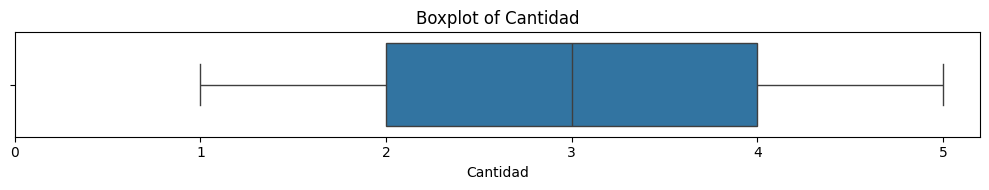

In [5]:
from app.utils import plot_utils

outliers_total, lower_total, upper_total = plot_utils.plot_boxplot_with_outliers('DetalleOrdenes', 'Cantidad', step=1)

### 5. Análisis de negocio

#### Número de ítems por orden

In [ ]:
from app.utils import postgres_utils, notebook_utils

query = """
SELECT
    o."OrdenID",
    COUNT(d."DetalleID") AS total_items
FROM "Ordenes" o
JOIN "DetalleOrdenes" d ON o."OrdenID" = d."OrdenID"
GROUP BY o."OrdenID"
ORDER BY total_items DESC
LIMIT 10;
"""
notebook_utils.print_colored("Número de ítems por orden", "green")
postgres_utils.run_query(query)

,OrdenID,total_items
0,114,23
1,901,21
2,168,20
3,175,19
4,429,19
5,131,19
6,96,19
7,976,19
8,174,18
9,775,18


In [ ]:
from app.utils import postgres_utils, notebook_utils

query = """
SELECT
    AVG(total_items) AS promedio_items_por_orden
FROM (
    SELECT
        o."OrdenID",
        COUNT(d."DetalleID") AS total_items
    FROM "Ordenes" o
    JOIN "DetalleOrdenes" d ON o."OrdenID" = d."OrdenID"
    GROUP BY o."OrdenID"
) subquery;
"""
notebook_utils.print_colored("Promedio de ítems por orden", "green")
postgres_utils.run_query(query)

,promedio_items_por_orden
0,10.0


In [3]:
from app.utils import notebook_utils

query="""
SELECT
    "OrdenID",
    SUM("Cantidad") AS total_items
FROM "DetalleOrdenes"
GROUP BY "OrdenID";"""

notebook_utils.print_colored("Distribución de items por orden", "green")
postgres_utils.run_query(query)

,OrdenID,total_items
0,652,29
1,273,29
2,51,58
3,951,13
4,70,25
...,...,...
995,520,30
996,55,45
997,148,40
998,790,12


In [4]:
from app.utils import notebook_utils, plot_utils, postgres_utils

query = """
SELECT
    "OrdenID",
    SUM("Cantidad") AS total_items
FROM "DetalleOrdenes"
GROUP BY "OrdenID";
"""

data_frame = postgres_utils.run_query(query)


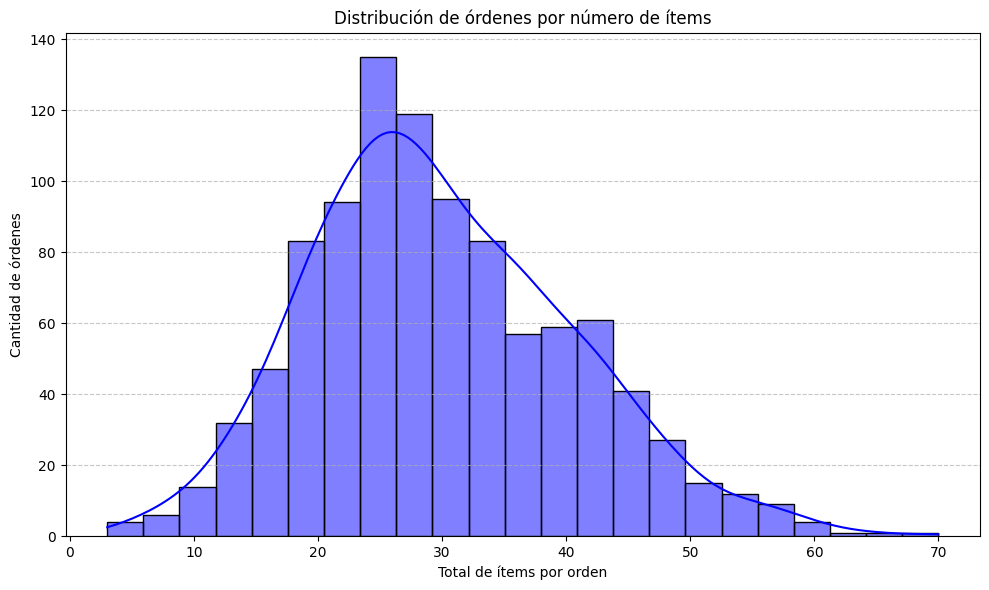

In [6]:
notebook_utils.print_colored("Distribución de órdenes por monto total", "green")
plot_utils.plot_histogram_with_outliers(df=data_frame, column='total_items', bins='auto', title='Distribución de órdenes por número de ítems', color='blue', label_x='Total de ítems por orden', label_y='Cantidad de órdenes') 

### 5. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `DetalleOrdenes`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 5.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** Se mantiene la estructura original.

#### 5.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto.

#### 5.3 Valores atípicos

- **Diagnóstico:** En la columna `Total`, el valor máximo (999.99) es alto respecto al Q3 (750.38), aunque no necesariamente inválido.
- **Acción propuesta:** 
  - Validar si esos valores son errores de carga o válidos.
  - Si son válidos, incluirlos y documentar como "transacciones altas" y tomar en cuenta para calculos 


#### 5.4 Consistencia de claves

- **DetalleID:** clave primaria válida, sin duplicados ni nulos.
- **OrdenID:** clave foránea consistente con la tabla `Ordenes`.
- **ProductoID:** clave foránea consistente con la tabla `Productos`.

- **Acción propuesta:**  Asegurar que las claves se mantengan válidas y con constraints activos en procesos de carga.

#### 5.5 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.

---

**Resumen general:**

| Aspecto                    | Acción requerida                            |
| -------------------------- | ------------------------------------------- |
| Valores nulos              | No                                          |
| Duplicados                 | No                                          |
| Outliers                   | No aparentes                                |
| Claves                     | Consistentes                                |
| Tipos de datos             | OK                                          |


#### Tabla: DireccionesEnvio

In [7]:
from app.utils import notebook_utils

notebook_utils.show_table_data("DireccionesEnvio")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DireccionID   1000 non-null   int64 
 1   UsuarioID     1000 non-null   int64 
 2   Calle         1000 non-null   object
 3   Ciudad        1000 non-null   object
 4   Departamento  1000 non-null   object
 5   Provincia     1000 non-null   object
 6   Distrito      1000 non-null   object
 7   Estado        1000 non-null   object
 8   CodigoPostal  1000 non-null   object
 9   Pais          1000 non-null   object
dtypes: int64(2), object(8)
memory usage: 78.3+ KB


None

,DireccionID,UsuarioID,Calle,Ciudad,Departamento,Provincia,Distrito,Estado,CodigoPostal,Pais
0,1,1,Diagonal Chilecito N° 335,Comodoro Rivadavia,Mendoza,Mendoza,Recoleta,Mendoza,10044733,Argentina
1,2,2,Diagonal Río Negro N° 497,Rawson,Tierra del Fuego,Tierra del Fuego,Palermo,Tierra del Fuego,76007280,Argentina
2,3,3,Blv. Formosa N° 118,Mar del Plata,Salta,Salta,Barracas,Salta,53604249,Argentina
3,4,4,Avenida La Rioja N° 612,San Juan,Neuquén,Neuquén,Flores,Neuquén,91031542,Argentina
4,5,5,Calle Neuquén N° 535,San Juan,Catamarca,Catamarca,Barracas,Catamarca,33002152,Argentina


#### 1. Información general

* Número de registros: 1000
* Número de columnas: 10

#### 2. Esquema

| Columna      | Tipo de dato | Valores no nulos | Observaciones                                        |
| ------------ | ------------ | ---------------- | ---------------------------------------------------- |
| DireccionID  | int64        | 1000             | Clave primaria.                                      |
| UsuarioID    | int64        | 1000             | Clave foránea a `Usuarios`.                          |
| Calle        | object       | 1000             | Texto libre.                                         |
| Ciudad       | object       | 1000             | Texto libre.                                         |
| Departamento | object       | 1000             | Texto libre, posible redundancia con `Provincia`.    |
| Provincia    | object       | 1000             | Texto libre.                                         |
| Distrito     | object       | 1000             | Texto libre. Puede no ser aplicable en todos países. |
| Estado       | object       | 1000             | Texto libre. Posible solapamiento con Provincia.     |
| CodigoPostal | object       | 1000             | Alfanumérico, no numérico.                           |
| Pais         | object       | 1000             | Texto libre. Requiere estandarización.               |

Observaciones
* No hay columnas con valores nulos.

* Los tipos de datos son consistentes con los atributos que describen.

* Las claves numéricas (DireccionID, UsuarioID) son consistentes y no tienen valores nulos.

* Se recomienda limpieza y estandarización de los campos de texto (mayúsculas, espacios, abreviaciones).

* Es conveniente evaluar la normalización de campos geográficos para evitar redundancia e inconsistencias.

In [10]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("DireccionesEnvio")

DireccionID     0.0
UsuarioID       0.0
Calle           0.0
Ciudad          0.0
Departamento    0.0
Provincia       0.0
Distrito        0.0
Estado          0.0
CodigoPostal    0.0
Pais            0.0
dtype: float64

np.int64(0)

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** Las claves numéricas (DireccionID, UsuarioID) son consistentes. 

* * **Clave primaria(s):** DireccionID, es unico y sin nulos

* * **Claves foráneas:** UsuarioID

In [7]:
from app.utils import postgres_utils, notebook_utils

data_frame = postgres_utils.run_query("SELECT * FROM \"DireccionesEnvio\";")

notebook_utils.print_colored(f"Exploración frecuencia por campos geográficos", "green")

notebook_utils.print_colored(f"Frecuencia datos únicos en País", "orange")
country_data = data_frame['Pais'].value_counts(dropna=False)
display(country_data)

notebook_utils.print_colored(f"Frecuencia datos únicos en Provincia", "orange")
province_data = data_frame['Provincia'].value_counts(dropna=False)
display(province_data)

notebook_utils.print_colored(f"Frecuencia datos únicos en Ciudad", "orange")
city_data= data_frame['Ciudad'].value_counts(dropna=False)
display(city_data)

notebook_utils.print_colored(f"Número de valores únicos para ver la granularidad", "green")

notebook_utils.print_colored(f"Frecuencia datos únicos en País", "orange")
country_data_unique = data_frame['Pais'].nunique()
display(country_data)

notebook_utils.print_colored(f"Frecuencia datos únicos en Provincia", "orange")
province_data_unique = data_frame['Provincia'].nunique()
display(province_data)

notebook_utils.print_colored(f"Frecuencia datos únicos en Ciudad", "orange")
city_data_unique= data_frame['Ciudad'].nunique()
display(city_data)

Pais
Argentina    1000
Name: count, dtype: int64

Provincia
Formosa                55
Chubut                 53
Tierra del Fuego       53
Salta                  52
La Pampa               47
Mendoza                47
Catamarca              46
San Juan               45
Neuquén                44
Córdoba                44
San Luis               44
Entre Ríos             43
Tucumán                43
Río Negro              42
Jujuy                  42
Chaco                  42
Misiones               40
Santa Fe               39
La Rioja               38
Santiago del Estero    37
Buenos Aires           36
Corrientes             34
Santa Cruz             34
Name: count, dtype: int64

Ciudad
San Juan                              49
Bahía Blanca                          43
Córdoba                               42
Resistencia                           41
Ushuaia                               40
Santa Fe                              39
Posadas                               39
Rawson                                38
Río Gallegos                          38
Santa Rosa                            37
La Rioja                              36
Merlo                                 35
Neuquén                               35
San Miguel de Tucumán                 34
Santiago del Estero                   33
Comodoro Rivadavia                    33
San Ferando del Valle de Catamarca    33
Rosario                               33
San Luis                              32
Formosa                               31
Chilecito                             30
La Plata                              29
Corrientes                            29
Mendoza                               28
Viedma   

Pais
Argentina    1000
Name: count, dtype: int64

Provincia
Formosa                55
Chubut                 53
Tierra del Fuego       53
Salta                  52
La Pampa               47
Mendoza                47
Catamarca              46
San Juan               45
Neuquén                44
Córdoba                44
San Luis               44
Entre Ríos             43
Tucumán                43
Río Negro              42
Jujuy                  42
Chaco                  42
Misiones               40
Santa Fe               39
La Rioja               38
Santiago del Estero    37
Buenos Aires           36
Corrientes             34
Santa Cruz             34
Name: count, dtype: int64

Ciudad
San Juan                              49
Bahía Blanca                          43
Córdoba                               42
Resistencia                           41
Ushuaia                               40
Santa Fe                              39
Posadas                               39
Rawson                                38
Río Gallegos                          38
Santa Rosa                            37
La Rioja                              36
Merlo                                 35
Neuquén                               35
San Miguel de Tucumán                 34
Santiago del Estero                   33
Comodoro Rivadavia                    33
San Ferando del Valle de Catamarca    33
Rosario                               33
San Luis                              32
Formosa                               31
Chilecito                             30
La Plata                              29
Corrientes                            29
Mendoza                               28
Viedma   

#### 4. Anáslisis estadístico
Para este caso dado que no hay datos numéricos relevantes, se analizaron algunos campos relevantes a nivel geográfico
__Pais__: 
- **Diagnóstico:** Solo se registran direcciones en un único país: Argentina.
- **Acción:** No se requiere limpieza en este campo, apriori. Sin embargo, se recomienda tabla auxiliar (Paises) para asegurar normalización 

__Provincia__: 
- **Diagnóstico:** Se registran 23 provincias distintas. Leve dispersión, siendo las más frecuentes: Formosa (55), Chubut (53), Tierra del Fuego (53).
- **Acción:** Considerar estandarización y uso de tabla auxiliar para normalizar provincias.

__Ciudad__: 
- **Diagnóstico:** Se detectan 30 ciudades distintas. Algunas ciudades aparecen con nombres largos o compuestos (San Ferando del Valle de Catamarca, San Miguel de Tucumán).
- **Acción:** Considerar estandarización y uso de tabla auxiliar para normalizar. Evaluar si conviene estructurar en una tabla geográfica con jerarquía Provincia -> Ciudad.

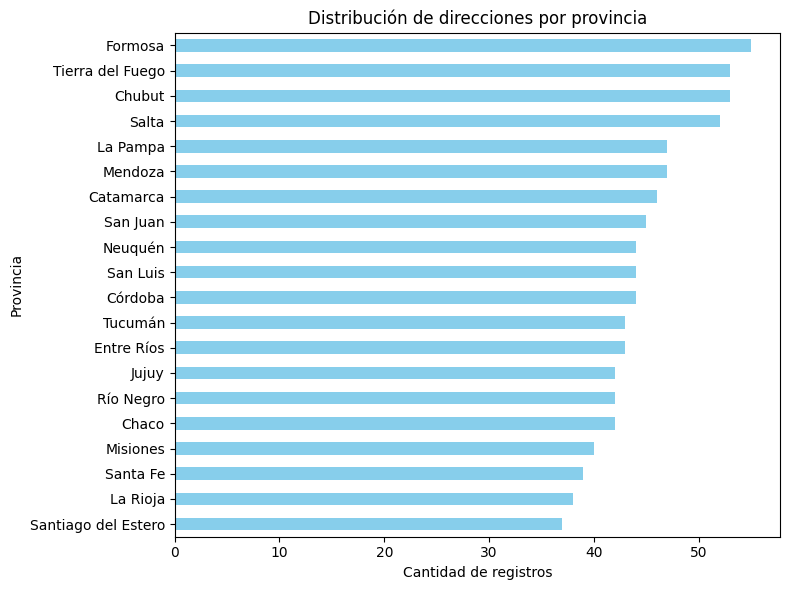

In [24]:
import matplotlib.pyplot as plt

province_data.head(20).sort_values().plot(
    kind='barh',
    figsize=(8, 6),
    color='skyblue'
)

plt.title('Distribución de direcciones por provincia')
plt.xlabel('Cantidad de registros')
plt.ylabel('Provincia')
plt.tight_layout()
plt.show()

### 4. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `DireccionesEnvio`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 4.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** No se requiere imputación o eliminación. Se mantiene la estructura original.

#### 4.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto. Se recomienda mantener chequeos periódicos al integrar datos nuevos.

#### 4.3 Valores atípicos

- **Diagnóstico:** Se identificaron valores atípicos en la columna `Precio`, con un máximo de 799 (muy por encima del tercer cuartil).
- **Acción propuesta:** 
  - Validar si esos valores son errores de carga o válidos.
  - Si se confirma que son errores, se sugiere establecer un límite superior al menos a instancias de reporte.
  - Si son válidos, mantenerlos pero tenerlos en cuenta para normalizaciones o transformaciones.

#### 4.4 Consistencia de claves

- **DireccionID:** clave primaria válida, sin duplicados ni nulos.
- **UsuarioID:** clave foránea consistente con la tabla `Usuarios`.

- **Acción propuesta:**  Asegurar que al importar datos se mantenga integridad referencial. Puede implementarse con constraints.

#### 4.5 Texto libre

- **Diagnóstico:** Varias columnas contienen texto libre (`Provincia`, `Ciudad`, `Calle`, etc.).
- **Acción propuesta:** 
  - Aplicar estandarización de capitalización y formato.
  - Eliminar caracteres especiales o inconsistencias si las hubiera.
  - Sugerencia: migrar a modelo relacional con tablas auxiliares (por ejemplo, Provincias, Paises) para normalizar estos campos y facilitar análisis geográficos.

#### 4.6 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.
- **Acción:** Sin cambios requeridos.

---

**Resumen general:**

| Aspecto            | Acción requerida                        |
| ------------------ | --------------------------------------- |
| Valores nulos      | No                                      |
| Duplicados         | No                                      |
| Texto libre        | Normalización y posible refactor        |
| Claves             | OK. Asegurar integridad con `Usuarios`  |
| Tipos de datos     | Consistentes                            |
| Mejora estructural | Tablas auxiliares para geografía        |


### Tabla: Carrito

In [11]:
from app.utils import notebook_utils

notebook_utils.show_table_data("Carrito")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CarritoID      5000 non-null   int64         
 1   UsuarioID      5000 non-null   int64         
 2   ProductoID     5000 non-null   int64         
 3   Cantidad       5000 non-null   int64         
 4   FechaAgregado  5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 195.4 KB


None

,CarritoID,UsuarioID,ProductoID,Cantidad,FechaAgregado
0,1,844,22,3,2025-04-29 10:15:10
1,2,901,7,2,2025-05-14 10:15:10
2,3,824,28,1,2025-04-26 10:15:10
3,4,94,5,3,2025-04-20 10:15:10
4,5,228,15,3,2025-05-11 10:15:10


#### 1. Información general

* Número de registros: 5000
* Número de columnas: 5

#### 2. Esquema

| Columna       | Tipo de dato    | Valores no nulos | Observaciones                                 |
| ------------- | --------------- | ---------------- | --------------------------------------------- |
| CarritoID     | int64           | 5000             | Clave primaria.                               |
| UsuarioID     | int64           | 5000             | Clave foránea a `Usuarios`.                   |
| ProductoID    | int64           | 5000             | Clave foránea a `Productos`.                  |
| Cantidad      | int64           | 5000             | Valor numérico, cantidad agregada al carrito. |
| FechaAgregado | datetime64\[ns] | 5000             | Fecha y hora en que se agregó el producto.    |

Observaciones
* No hay columnas con valores nulos.
* No hay columnas con valores nulos.
* Los tipos de datos son consistentes con los atributos que describen. 

In [12]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("Carrito")

CarritoID        0.0
UsuarioID        0.0
ProductoID       0.0
Cantidad         0.0
FechaAgregado    0.0
dtype: float64

np.int64(0)

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** Las claves numéricas (ProductoID, UsuarioID) son consistentes. 

* * **Clave primaria(s):** CarritoID, es unico y sin nulos

* * **Claves foráneas:** ProductoID, UsuarioID

In [13]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("Carrito")

,CarritoID,UsuarioID,ProductoID,Cantidad,FechaAgregado
count,5000.000000,5000.000000,5000.000000,5000.000000,5000
mean,2500.500000,505.033000,18.414000,2.006200,2025-05-17 01:53:28.240000256
min,1.000000,1.000000,1.000000,1.000000,2025-04-01 10:15:10
25%,1250.750000,248.000000,10.000000,1.000000,2025-04-25 10:15:10
50%,2500.500000,506.000000,18.000000,2.000000,2025-05-17 10:15:10
75%,3750.250000,762.000000,27.000000,3.000000,2025-06-08 10:15:10
max,5000.000000,1000.000000,36.000000,3.000000,2025-06-30 10:15:10
std,1443.520003,293.110682,10.308009,0.813569,NaN


#### 4. Anáslisis estadístico
Se evalúa la columna Cantidad, ya que representa el comportamiento del usuario respecto a cuántas unidades de un producto agregó al carrito.

__Cantidad__: La desviación estándar es baja (0.81) lo que indica baja dispersion, que coincide con lo sugerido por la media y la mediana

* * La media y la mediana están muy próximas (~2), lo que sugiere una distribución simétrica.

* * El valor mínimo es 1 (lo esperado considerando numero de items)  y el máximo es 3.

* * Aparenta una baja dispersión , que se confirmará en análisis gráfico


Se evalúa la columna FechaAgregado, ya que puede aportar información de estacionalidad

__FechaAgregado__: 

* * Los valores abarcan desde el 1 de abril de 2025 hasta el 30 de junio de 2025.

* * Puede utilizarse para explorar tendencias temporales, como frecuencia de agregado por día o mes.

#### 5. Análisis de negocio

##### 5.1 Distribución de ítems agregados por producto

In [17]:
from app.utils import notebook_utils, postgres_utils
query = """
SELECT 
    p."Nombre",
    COUNT(*) AS veces_agregado,
    SUM(c."Cantidad") AS cantidad_total
FROM "Carrito" c
JOIN "Productos" p ON c."ProductoID" = p."ProductoID"
GROUP BY p."Nombre"
ORDER BY cantidad_total DESC
LIMIT 10;
"""
notebook_utils.print_colored("Productos más agregados al carrito", "green")
postgres_utils.run_query(query)

,Nombre,veces_agregado,cantidad_total
0,Multivitamínico Centrum,155,338
1,Muñeca Barbie Original,157,331
2,Control Xbox Series X,157,325
3,Alcohol en Gel 500ml,163,323
4,Camiseta Básica Hombre,152,321
5,Lámpara de Escritorio LED,151,313
6,Consola PlayStation 5,150,302
7,Libro: Cien Años de Soledad,158,299
8,Laptop Dell Inspiron 15,139,297
9,Pelota de Fútbol Profesional,148,291


##### 5.2. Tendencia diaria de carritos
- Para ver la estacionalidad o hábitos según la fecha (frecuencia de uso del carrito).


In [24]:
from app.utils import notebook_utils, postgres_utils
query = """
SELECT 
    DATE("FechaAgregado") AS fecha,
    TO_CHAR("FechaAgregado", 'Day') AS dia_semana,
    COUNT(*) AS total_agregados,
    SUM("Cantidad") AS cantidad_total
FROM "Carrito"
GROUP BY fecha, dia_semana
ORDER BY cantidad_total DESC;
"""

df = postgres_utils.run_query(query)

added_average = df['total_agregados'].mean()
notebook_utils.print_colored("Tendencia diaria de carritos agregados", "green")
notebook_utils.print_colored(f"Promedio de carritos agregados por día: {added_average}", "orange")
df 


,fecha,dia_semana,total_agregados,cantidad_total
0,2025-05-12,Monday,78,143
1,2025-06-06,Friday,67,142
2,2025-06-09,Monday,67,141
3,2025-05-03,Saturday,70,139
4,2025-06-04,Wednesday,64,137
...,...,...,...,...
86,2025-06-29,Sunday,46,88
87,2025-04-02,Wednesday,42,88
88,2025-04-18,Friday,39,79
89,2025-04-01,Tuesday,43,75


In [25]:
from app.utils import notebook_utils, postgres_utils

query = """
SELECT 
    TRIM(TO_CHAR("FechaAgregado", 'Day')) AS dia_semana,
    COUNT(*) AS total_agregados,
    SUM("Cantidad") AS cantidad_total,
    ROUND(AVG("Cantidad")::numeric, 2) AS promedio_cantidad
FROM "Carrito"
GROUP BY dia_semana
ORDER BY total_agregados DESC;
"""

notebook_utils.print_colored("Tendencia de carritos agregados por día de la semana", "green")
postgres_utils.run_query(query)

,dia_semana,total_agregados,cantidad_total,promedio_cantidad
0,Monday,744,1485,2.00
1,Saturday,743,1511,2.03
2,Wednesday,732,1486,2.03
3,Sunday,709,1400,1.97
4,Friday,702,1403,2.00
5,Tuesday,701,1382,1.97
6,Thursday,669,1364,2.04


In [26]:
from app.utils import notebook_utils, postgres_utils

query = """
SELECT 
    p."Nombre",
    COUNT(d."Cantidad") AS veces_vendido,
    SUM(d."Cantidad") AS cantidad_vendida
FROM "Productos" p 
JOIN "DetalleOrdenes" d ON p."ProductoID" = d."ProductoID"
GROUP BY p."Nombre"
ORDER BY cantidad_vendida DESC
LIMIT 10;
"""
notebook_utils.print_colored("Productos más vendidos", "green")
postgres_utils.run_query(query)

,Nombre,veces_vendido,cantidad_vendida
0,Juego de Mesa Monopoly,302,942
1,Consola PlayStation 5,310,935
2,Termómetro Digital,291,898
3,Jeans Skinny Mujer,291,887
4,Smartwatch Xiaomi Mi Band 8,288,887
5,Mini Proyector LED,288,885
6,Cuaderno Universitario 100h,295,876
7,Arenero para Gato,294,874
8,Camiseta Básica Hombre,296,868
9,Set de Lápices de Colores,279,856


### 6. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `Carrito`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 6.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** Se mantiene la estructura original.

#### 6.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto.

#### 6.3 Valores atípicos

- **Diagnóstico:** La columna Cantidad muestra valores entre 1 y 3. No se detectan valores fuera de rango ni anomalías evidentes.
- **Acción propuesta:** :No se requieren transformaciones


#### 6.4 Consistencia de claves

- **CarritoID:** clave primaria válida, sin duplicados ni nulos.
- **UsuarioID:** clave foránea consistente con la tabla `Usuarios`.
- **ProductoID:** clave foránea consistente con la tabla `Productos`.

- **Acción propuesta:**  Asegurar que las claves se mantengan válidas y con constraints activos en procesos de carga.

#### 6.5 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.

---

**Resumen general:**

| Aspecto        | Acción requerida                         |
| -------------- | ---------------------------------------- |
| Valores nulos  | No                                       |
| Duplicados     | No                                       |
| Outliers       | No. Rango controlado en `Cantidad`       |
| Claves         | OK. Validar integridad en futuras cargas |


### Tabla: MetodosPago

In [4]:
from app.utils import notebook_utils

notebook_utils.show_table_data("MetodosPago")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MetodoPagoID  7 non-null      int64 
 1   Nombre        7 non-null      object
 2   Descripcion   7 non-null      object
dtypes: int64(1), object(2)
memory usage: 300.0+ bytes


None

,MetodoPagoID,Nombre,Descripcion
0,1,Tarjeta de Crédito,"Pago con tarjeta de crédito VISA, MasterCard o..."
1,2,Tarjeta de Débito,Pago con tarjeta de débito emitida por cualqui...
2,3,Transferencia Bancaria,Transferencia directa a nuestra cuenta bancaria
3,4,Pago Contra Entrega,Paga en efectivo cuando recibes tu pedido
4,5,Mercado Pago,Pago a través de la pasarela Mercado Pago


### 1. Información general

Número de registros: 7
Número de columnas: 3

### 2. Esquema de columnas

| Columna       | Tipo de dato    | Valores no nulos | Observaciones          |
| ------------- | --------------- | ---------------- | -----------------------|
| MetodoPagoID  | int64           | 7                | Clave primaria.        |
| Nombre        | object          | 7                | Nombre medio de pago.  |
| Descripcion   | object          | 7                | Describe medio de pago |



### 3. Observaciones generales
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** Los tipos de datos son adecuados.

* Claves:

**Clave primaria(s):** MetodoPagoID

**Claves foráneas:** .-

**Limpieza potencial:** columnas como `Nombre` podrían requerir normalización o validación de categorías.

### 4. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `Metodos de pago`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 4.1 Valores nulos o duplicado

- **Diagnóstico:** No se encontraron columnas con valores nulos ni filas duplicadas
- **Acción:** Se mantiene la estructura original.

#### 4.2 Consistencia de claves

- **MetodoPagoID:** clave primaria válida, sin duplicados ni nulos.

- **Acción propuesta:**  Asegurar que las claves se mantengan válidas y con constraints activos en procesos de carga.

#### 4.5 Tipos de datos
- Todos los tipos de datos son consistentes con el dominio del atributo.

#### 4.5 Texto libre
- **Diagnóstico:** La columna `Nombre` contiene texto libre, lo cual podría generar inconsistencias si se repiten registros con variantes tipográficas (mayúsculas, espacios, etc.).
- **Acción:**
- - Validar que Nombre contenga valores únicos y estandarizados.
- - Mantener esta tabla como auxiliar de medios de pago, usando la clave MetodoPagoID para referencias externas.Esta estructura podría facilitar futuras extensiones (como agregar marcas de tarjeta o condiciones específicas por método).

---

**Resumen general:**

| Aspecto            | Acción requerida                                  |
| ------------------ | ------------------------------------------------- |
| Valores nulos      | No                                                |
| Duplicados         | No                                                |
| Claves             | OK. Validar integridad referencial si corresponde |
| Tipos de datos     | OK                                                |
| Estandarización    | Recomendada en `Nombre`                           |
| Mejora estructural | Mantener como tabla auxiliar                      |


### Tabla: OrdenesMetodosPago

In [5]:
from app.utils import notebook_utils

notebook_utils.show_table_data("OrdenesMetodosPago")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OrdenMetodoID  10000 non-null  int64  
 1   OrdenID        10000 non-null  int64  
 2   MetodoPagoID   10000 non-null  int64  
 3   MontoPagado    10000 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 312.6 KB


None

,OrdenMetodoID,OrdenID,MetodoPagoID,MontoPagado
0,1,1,2,580.22
1,2,2,4,638.87
2,3,3,7,946.09
3,4,4,2,390.35
4,5,5,3,908.67


#### 1. Información general
- Número de registros: 10000

- Número de columnas: 4

#### 2. Esquema de columnas
 
| Columna         | Tipo de dato | Valores no nulos | Observaciones                                                       |
| --------------- | ------------ | ---------------- | ------------------------------------------------------------------- |
| `OrdenMetodoID` | int64        | 10,000           | Clave primaria. Identificador único del registro de pago por orden. |
| `OrdenID`       | int64        | 10,000           | Clave foránea a `Ordenes`.                                          |
| `MetodoPagoID`  | int64        | 10,000           | Clave foránea a `MetodosPago`.                                      |
| `MontoPagado`   | float64      | 10,000           | Monto abonado por ese método en la orden.                           |



In [6]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("OrdenesMetodosPago")


OrdenMetodoID    0.0
OrdenID          0.0
MetodoPagoID     0.0
MontoPagado      0.0
dtype: float64

np.int64(0)



#### 3. Observaciones generales
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** Los tipos de datos son adecuados.

* Claves:

**Clave primaria(s):** OrdenMetodoID

**Claves foráneas:** OrdenID, MetodoPagoID, consistentes. 


In [7]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("OrdenesMetodosPago")


,OrdenMetodoID,OrdenID,MetodoPagoID,MontoPagado
count,10000.00000,10000.00000,10000.000000,10000.000000
mean,5000.50000,5000.50000,4.043400,551.040996
std,2886.89568,2886.89568,1.995925,262.069448
min,1.00000,1.00000,1.000000,100.050000
25%,2500.75000,2500.75000,2.000000,319.860000
50%,5000.50000,5000.50000,4.000000,554.265000
75%,7500.25000,7500.25000,6.000000,777.910000
max,10000.00000,10000.00000,7.000000,999.950000



#### 4. Anáslisis estadístico
Se evalúa la columna `MontoPagado:`, que representa el importe abonado por cada método de pago vinculado a una orden. 

__MontoPagado__: La desviación estándar es baja (262) lo que indica bastante dispersion, lo cual es esperable considerando la dispersion de precios en los productos y la posibilidad de desglosar una misma orden en varios medios de pago

* * La media y la mediana están muy próximas (~551.04-554.26), lo que sugiere una distribución simétrica.

* * El valor mínimo registrado es 100.05 y el máximo 999.95, lo que abarca prácticamente el rango total de pagos posibles en la plataforma.

* * Aparenta una considerable dispersión , que se confirmará en análisis gráfico


Number of outliers in 'MontoPagado': 0


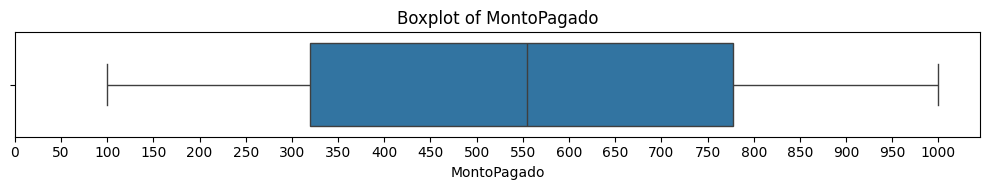

In [7]:
from app.utils import plot_utils

outliers, lower, upper = plot_utils.plot_boxplot_with_outliers('OrdenesMetodosPago', 'MontoPagado', step=50)

### 5. Análisis de Negocio

#### 5.1 ¿Cuáles son los métodos de pago más utilizados?


In [8]:
from app.utils import postgres_utils, notebook_utils

query = """
SELECT 
    mp."MetodoPagoID",
    mp."Nombre",
    COUNT(omp."OrdenMetodoID") AS total_ordenes,
    SUM(omp."MontoPagado") AS total_pagado
FROM "MetodosPago" mp
JOIN "OrdenesMetodosPago" omp ON mp."MetodoPagoID" = omp."MetodoPagoID"
GROUP BY mp."MetodoPagoID", mp."Nombre"
ORDER BY total_ordenes DESC, total_pagado DESC
LIMIT 10;
"""
notebook_utils.print_colored("Ranking de métodos de pago por cantidad de órdenes y monto total pagado", "green")
postgres_utils.run_query(query)

,MetodoPagoID,Nombre,total_ordenes,total_pagado
0,7,Crédito en Tienda,1493,809547.11
1,4,Pago Contra Entrega,1458,810915.91
2,5,Mercado Pago,1434,791496.47
3,3,Transferencia Bancaria,1428,795988.89
4,6,PayPal,1421,792336.04
5,2,Tarjeta de Débito,1405,765149.21
6,1,Tarjeta de Crédito,1361,744976.33


#### 5.2 ¿Cuál es el monto promedio pagado por método de pago?


In [ ]:
from app.utils import notebook_utils
query = """
SELECT
    mp."MetodoPagoID",
    mp."Nombre",
    AVG(omp."MontoPagado") AS monto_promedio
FROM "MetodosPago" mp
JOIN "OrdenesMetodosPago" omp ON mp."MetodoPagoID" = omp."MetodoPagoID"
GROUP BY mp."MetodoPagoID", mp."Nombre"
ORDER BY monto_promedio DESC;
"""
notebook_utils.print_colored("Monto promedio pagado por método de pago", "green")
postgres_utils.run_query(query)

,MetodoPagoID,Nombre,monto_promedio
0,6,PayPal,557.590457
1,3,Transferencia Bancaria,557.415189
2,4,Pago Contra Entrega,556.183752
3,5,Mercado Pago,551.950119
4,1,Tarjeta de Crédito,547.374232
5,2,Tarjeta de Débito,544.590185
6,7,Crédito en Tienda,542.228473


#### 5.3 ¿Cuántas órdenes se pagaron usando más de un método de pago?

In [11]:
from app.utils import notebook_utils, postgres_utils

query = """
SELECT
    COUNT(DISTINCT omp."OrdenID") AS total_ordenes_multipago
FROM "OrdenesMetodosPago" omp
GROUP BY omp."OrdenID"      
HAVING COUNT(omp."MetodoPagoID") > 1;
"""
notebook_utils.print_colored("Órdenes pagadas con más de un método de pago", "green")
postgres_utils.run_query(query)

,total_ordenes_multipago


Como la consulta anterior no devuelve resultados se confirma consutlando si exiten OrderID duplicados en la columna.

In [ ]:
from app.utils import postgres_utils
query = """
SELECT "OrdenID", COUNT(*) AS count
FROM "OrdenesMetodosPago"
GROUP BY "OrdenID"
HAVING COUNT(*) > 1;
"""
postgres_utils.run_query(query)


,OrdenID,count


#### 5.4 ¿Cuál es el monto total recaudado por mes?

In [15]:

from app.utils import notebook_utils, postgres_utils

query = """
SELECT
    DATE_TRUNC('month', o."FechaOrden") AS mes,
    SUM(omp."MontoPagado") AS total_recaudado
FROM "OrdenesMetodosPago" omp
JOIN "Ordenes" o ON omp."OrdenID" = o."OrdenID"
WHERE o."Estado" = 'Completado'
GROUP BY mes
ORDER BY mes;
"""

notebook_utils.print_colored("Monto total recaudado por mes", "green")
postgres_utils.run_query(query)

,mes,total_recaudado
0,2024-06-01,3002.38
1,2024-07-01,112090.68
2,2024-08-01,121851.46
3,2024-09-01,96583.59
4,2024-10-01,111964.16
5,2024-11-01,119685.79
6,2024-12-01,112424.46
7,2025-01-01,109085.11
8,2025-02-01,102703.50
9,2025-03-01,112856.12


### 6. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `'OrdenesMetodosPago'`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 6.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** Se mantiene la estructura original.

#### 6.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto.

#### 6.3 Valores atípicos

- **Diagnóstico:** Los valores de `MontoPagado` oscilan entre 100.05 y 999.95, sin valores fuera de un rango lógico.
- **Acción propuesta:** :No se requieren transformaciones, la distribución es simetrica y no hay outliers :
- - Dispersión: El rango intercuartílico (IQR) va de aproximadamente 319.86 a 777.91, y la mediana es cercana a la media (554.27), lo que sugiere una distribución simétrica y sin sesgo evidente.

Visualización: Un boxplot muestra una distribución pareja, sin valores atípicos destacables.


#### 6.4 Consistencia de claves

- **OrdenMetodoID:** clave primaria válida, sin duplicados ni nulos.
- **OrdenID:** clave foránea consistente con la tabla `Ordenes`.
- **MetodoPagoID:** clave foránea consistente con la tabla `MetodosPago`.

- **Acción propuesta:**  Asegurar que las claves se mantengan válidas y con constraints activos en procesos de carga.

#### 6.5 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.

---

**Resumen general:**

| Aspecto        | Acción requerida                            |
| -------------- | ------------------------------------------- |
| Valores nulos  | No                                          |
| Duplicados     | No                                          |
| Outliers       | No evidentes, dispersión moderada en montos |
| Claves         | OK. Validar integridad en futuras cargas    |
| Tipos de datos | Consistentes                                |


#### Tabla: ReseñasProductos


In [14]:
from app.utils import notebook_utils

notebook_utils.show_table_data("ReseñasProductos")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ReseñaID      10000 non-null  int64         
 1   UsuarioID     10000 non-null  int64         
 2   ProductoID    10000 non-null  int64         
 3   Calificacion  10000 non-null  int64         
 4   Comentario    10000 non-null  object        
 5   Fecha         10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 468.9+ KB


None

,ReseñaID,UsuarioID,ProductoID,Calificacion,Comentario,Fecha
0,1,898,10,1,"Mala calidad, no lo recomiendo. Ullam sint ali...",2025-07-22 03:25:35.284709
1,2,700,16,3,El producto es aceptable por el precio. Quisqu...,2025-07-22 03:25:35.284828
2,3,173,13,2,"Mala calidad, no lo recomiendo. Illum corporis...",2025-07-22 03:25:35.284867
3,4,557,20,2,No cumplió con lo prometido. Tempore distincti...,2025-07-22 03:25:35.284895
4,5,448,33,2,No cumplió con lo prometido. Modi doloribus re...,2025-07-22 03:25:35.284918



1. Información general
Número de registros: 10000
Número de columnas: 6

2. Esquema de columnas
 
| Columna        | Tipo de dato    | Valores no nulos | Observaciones                                                     |
| -------------- | --------------- | ---------------- | ----------------------------------------------------------------- |
| `ReseñaID`     | int64           | 10,000           | Clave primaria. Identificador único de cada reseña.               |
| `UsuarioID`    | int64           | 10,000           | Clave foránea a `Usuarios`.                                       |
| `ProductoID`   | int64           | 10,000           | Clave foránea a `Productos`.                                      |
| `Calificacion` | int64           | 10,000           | Escala discreta de 1 a 5. Restricción CHECK definida.             |
| `Comentario`   | object (texto)  | 10,000           | Texto libre. Puede requerir limpieza (espacios, caracteres, etc). |
| `Fecha`        | datetime64\[ns] | 10,000           | Fecha y hora de la reseña.           |


In [15]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("ReseñasProductos")


CarritoID        0.0
UsuarioID        0.0
ProductoID       0.0
Cantidad         0.0
FechaAgregado    0.0
dtype: float64

np.int64(0)

3. Observaciones generales
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** Los tipos de datos son adecuados

* Claves:

**Clave primaria(s):** ReseñaID, única y sin valores nulos.

**Claves foráneas:** UsuarioID y ProductoID, ambas apuntan a las tablas Usuarios y Productos respectivamente.

**Limpieza potencial:** columnas como ... podrían requerir normalización, limpieza de texto o validación de categorías.



In [17]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("ReseñasProductos")

,ReseñaID,UsuarioID,ProductoID,Calificacion,Fecha
count,10000.00000,10000.000000,10000.000000,10000.000000,10000
mean,5000.50000,500.963600,18.563400,2.995500,2025-07-22 03:25:35.385861888
min,1.00000,1.000000,1.000000,1.000000,2025-07-22 03:25:35.284709
25%,2500.75000,252.000000,10.000000,2.000000,2025-07-22 03:25:35.326602752
50%,5000.50000,506.000000,19.000000,3.000000,2025-07-22 03:25:35.392456448
75%,7500.25000,754.000000,28.000000,4.000000,2025-07-22 03:25:35.437829888
max,10000.00000,1000.000000,36.000000,5.000000,2025-07-22 03:25:35.478361
std,2886.89568,287.968426,10.344065,1.400384,NaN



#### 4. Anáslisis estadístico
Se evalúa la columna `Calificacion`, ya que representa la opinión del usuario sobre un producto.

__Calificacion__: La desviación estándar (1.40) indica una dispersión moderada, lo cual es esperable dado el rango de 5 niveles posibles.

* * La media (2.99) y la mediana (3) están prácticamente alineadas, lo que sugiere una distribución simétrica.

* * El valor mínimo es 1 y el máximo es 5, dentro del rango permitido por la restricción CHECK.




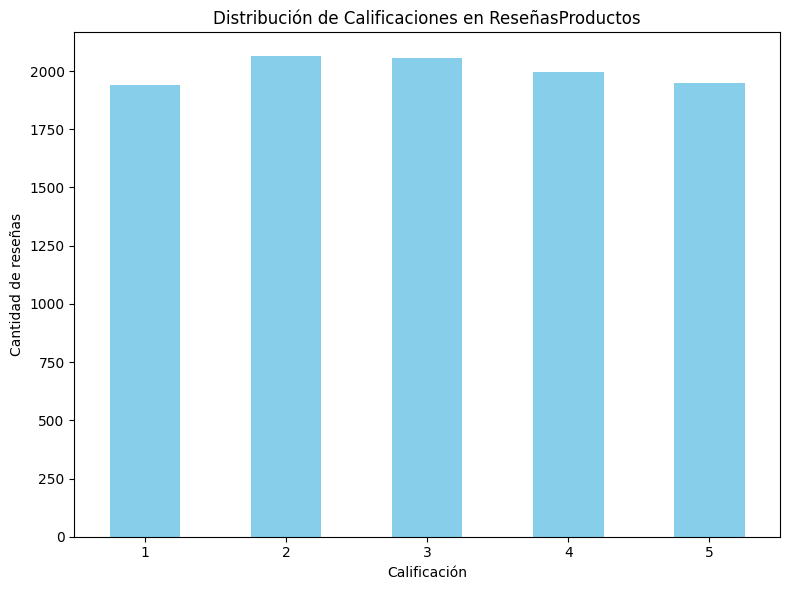

In [ ]:
import matplotlib.pyplot as plt

data_frame = postgres_utils.run_query("SELECT \"Calificacion\" FROM \"ReseñasProductos\";")
frequency = frecuencias = data_frame['Calificacion'].value_counts().sort_index()
frequency.plot(
    kind='bar',
    figsize=(8, 6),
    color='skyblue'
)

plt.title('Distribución de Calificaciones en ReseñasProductos')
plt.xlabel('Calificación')
plt.ylabel('Cantidad de reseñas')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 5. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `ReseñasProductos`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 5.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** Se mantiene la estructura original.

#### 5.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto.

#### 5.3 Valores atípicos

- **Diagnóstico:** La columna Cantidad muestra valores entre 1 y 5.  conforme al rango esperado y sin valores fuera de rango ni anomalías.
- **Acción propuesta:** :No se requieren transformaciones


#### 5.4 Consistencia de claves

- **ReseñaID:** clave primaria válida, sin duplicados ni nulos.
- **UsuarioID:** clave foránea consistente con la tabla `Usuarios`.
- **ProductoID:** clave foránea consistente con la tabla `Productos`.

- **Acción propuesta:**  Asegurar que las claves se mantengan válidas y con constraints activos en procesos de carga.

#### 5.5 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.

---
| Aspecto        | Acción requerida                                  |
| -------------- | ------------------------------------------------- |
| Valores nulos  | No                                                |
| Duplicados     | No                                                |
| Outliers       | No, rango esperado y controlado en `Calificacion` |
| Claves         | OK. Validar integridad en futuras cargas          |
| Tipos de datos | Adecuados, posible limpieza en texto `Comentario` |
| Distribución   | Balanceada, no requiere ajustes                   |


In [21]:
from app.utils import notebook_utils

notebook_utils.show_table_data("HistorialPagos")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   PagoID        10000 non-null  int64         
 1   OrdenID       10000 non-null  int64         
 2   MetodoPagoID  10000 non-null  int64         
 3   Monto         10000 non-null  float64       
 4   FechaPago     10000 non-null  datetime64[ns]
 5   EstadoPago    10000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 468.9+ KB


None

,PagoID,OrdenID,MetodoPagoID,Monto,FechaPago,EstadoPago
0,1,1,4,147.13,2025-07-22 03:25:37.199927,pending
1,2,2,1,647.98,2025-07-22 03:25:37.200268,pending
2,3,3,6,627.45,2025-07-22 03:25:37.200343,pending
3,4,4,5,848.07,2025-07-22 03:25:37.200381,pending
4,5,5,5,189.80,2025-07-22 03:25:37.200421,pending


#### Tabla: HistorialPagos

1. Información general
Número de registros: 10000
Número de columnas: 6

2. Esquema de columnas
 
| Columna        | Tipo de dato    | Valores no nulos | Observaciones                                       |
| -------------- | --------------- | ---------------- | --------------------------------------------------- |
| `PagoID`       | `SERIAL`        | 10000            | Clave primaria, identificador único de pago.        |
| `OrdenID`      | `INT`           | 10000            | Clave foránea referenciando la tabla `Ordenes`.     |
| `MetodoPagoID` | `INT`           | 10000            | Clave foránea referenciando la tabla `MetodosPago`. |
| `Monto`        | `DECIMAL(10,2)` | 10000            | Monto total del pago realizado.                     |
| `FechaPago`    | `TIMESTAMP`     | 10000            | Fecha y hora del pago.                              |
| `EstadoPago`   | `VARCHAR(50)`   | 10000            | Estado del pago, por defecto 'Procesando'.          |



In [22]:

from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("HistorialPagos")

PagoID          0.0
OrdenID         0.0
MetodoPagoID    0.0
Monto           0.0
FechaPago       0.0
EstadoPago      0.0
dtype: float64

np.int64(0)

In [ ]:

### 3. Observaciones generales
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados (df.duplicated().sum()).

* **Tipos de datos:** Los tipos de datos son adecuados

* Claves:

**Clave primaria(s):** PagoID

**Claves foráneas:** 
 * * OrdenID es clave foránea consistente con la tabla Ordenes.
    * * MetodoPagoID es clave foránea consistente con la tabla MetodosPago.

**Limpieza potencial:** La columna EstadoPago es candidata a normalización o refactor
        


In [23]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("HistorialPagos")


,PagoID,OrdenID,MetodoPagoID,Monto,FechaPago
count,10000.00000,10000.00000,10000.000000,10000.000000,10000
mean,5000.50000,5000.50000,4.013800,551.020499,2025-07-22 03:25:37.338594304
min,1.00000,1.00000,1.000000,100.030000,2025-07-22 03:25:37.199927
25%,2500.75000,2500.75000,2.000000,328.212500,2025-07-22 03:25:37.270445056
50%,5000.50000,5000.50000,4.000000,549.000000,2025-07-22 03:25:37.336937472
75%,7500.25000,7500.25000,6.000000,779.440000,2025-07-22 03:25:37.407772928
max,10000.00000,10000.00000,7.000000,999.730000,2025-07-22 03:25:37.519935
std,2886.89568,2886.89568,1.990378,260.458342,NaN




#### 4. Anáslisis estadístico
A partir de las estadísticas descriptivas de las columnas de la tabla HistorialPagos, tenemos los siguientes puntos relevantes:


__Monto__: 
* * Desviación estándar: 260.46, lo que significa que hay una considerable variabilidad en los montos, lo que sugiere que la tabla incluye una gama amplia de pagos.

* * La media es 551.02
* * El valor mínimo es apx 100 y el máximo 999.73, lo cual conincide con análisis previos vinculados a pagos.

Se evalúa la columna FechaAgregado, ya que pede aportar información de estacionalidad

__MetodoPagoID__:
* * Valor mínimo 1 y máximo 7, estos referen a los Ids y están dentro del rango de medios de pago disponibles.


#### 5. Análisis de negocio

#### 5.1¿Cuántos pagos están en estado 'Procesando' o 'Fallido'?


In [2]:
from app.utils import notebook_utils, postgres_utils

query = """
SELECT
    COUNT(*) AS total_pagos_procesando_fallido
FROM "HistorialPagos"
WHERE "EstadoPago" IN ('Procesando', 'Fallido');
"""
notebook_utils.print_colored("Total de pagos en estado 'Procesando' o 'Fallido'", "green")
postgres_utils.run_query(query)


,total_pagos_procesando_fallido
0,5088


Proporción de cada estado.

In [1]:
from app.utils import notebook_utils, postgres_utils
query = """
SELECT "EstadoPago", COUNT(*) AS cantidad
FROM "HistorialPagos"
GROUP BY "EstadoPago"
ORDER BY cantidad DESC;
"""
notebook_utils.print_colored("Proporción de cada estado de pago", "green")
postgres_utils.run_query(query) 

,EstadoPago,cantidad
0,Fallido,2546
1,Procesando,2542
2,Pagado,2457
3,Reembolsado,2455


### 5. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `HistorialPagos`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 5.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** Se mantiene la estructura original.

#### 5.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto.

#### 5.3 Valores atípicos

- **Diagnóstico:** El campo Monto tiene pagos con un rango entre 100.03 y 999.73. Sin embargo, dada la alta desviación estándar (260.46), es recomendable analizar los valores extremos más cercanos al máximo para verificar si corresponden a transacciones legítimas.
- **Acción propuesta:** :No se requieren transformaciones


#### 5.4 Consistencia de claves

- **PagoID:** clave primaria válida, sin duplicados ni nulos.
- **OrdenID:** clave foránea consistente con la tabla `Ordenes`.
- **MetodoPagoID:** clave foránea consistente con la tabla `MetodosPago`.

- **Acción propuesta:**  Asegurar que las claves se mantengan válidas y con constraints activos en procesos de carga.

#### 5.5 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.

#### 5.6 Texto libre

- **Diagnóstico:** La columna `EstadoPago` es un campo de texto con posibles valores categóricos como 'Pendiente', 'Pagado', 'Procesado','Fallido', 'Reembolsado'.
- **Acción propuesta:** 
  - Propuesta de mejora estructural: extraer los estados a una tabla aparte y usar un FOREIGN KEY en lugar del texto.

---

**Resumen general:**

| Aspecto        | Acción requerida                                                                         |
| -------------- | ---------------------------------------------------------------------------------------- |
| Valores nulos  | No                                                                                       |
| Duplicados     | No                                                                                       |
| Outliers       | Revisar pagos extremos en `Monto`                                                        |
| Claves         | Validar integridad referencial en futuras cargas                                         |
| Tipos de datos | Adecuados, sin necesidad de transformaciones                                             |
| EstadoPago     | Asegurarse de que los pagos se actualicen a "confirmado" o "cancelado" según corresponda |
